In [ ]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ)), use exact value to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x+0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
end

plot_entanglement_spectrum (generic function with 1 method)

In [3]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [4]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLT.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(tri_lattice,
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [5]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 1.0                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:10; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:10; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.0; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.6341991947102161, 0.7488598133546632, 0.5281765904875219, 0.41825804439856695, 0.34986803155496876, 0.30223593222762896, 0.266707499725575, 0.23895575700640043, 0.21654690215344488, 0.19799371629995444, 0.18232959739735166]
inter_PP = [0.9536152926614218, 0.636026219573564, 0.4834882387026461, 0.39388037090686623, 0.33424593599922947, 0.2912399244753895, 0.2584849301718478, 0.2325435446759757, 0.21139046639862796, 0.19374888446058133, 0.17877024474768707]


In [6]:
# number of electrons in each layer
Ne1 = 4
Ne2 = 8

8

In [7]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para_conserve, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [8]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatterList_twobody(para_conserve);

12-element Vector{Int64}:
 20436
 20436
 20436
 20400
 20400
 20400
 20439
 20439
 20439
 20400
 20400
 20400

In [9]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 20436, momentum 0, 0
  1.619019 seconds (84.64 M allocations: 3.438 GiB, 41.56% gc time, 59.09% compilation time)
  4.679851 seconds (5.65 M allocations: 594.979 MiB, 1.27% gc time, 65.37% compilation time)
Processing subspace #2 with size 20436, momentum 0, 1
  1.155123 seconds (83.89 M allocations: 3.402 GiB, 58.93% gc time)
  1.561185 seconds (12.79 k allocations: 241.577 MiB, 0.79% gc time)
Processing subspace #3 with size 20436, momentum 0, 2
  1.001897 seconds (83.89 M allocations: 3.402 GiB, 49.69% gc time)
  1.649165 seconds (12.56 k allocations: 232.198 MiB, 7.68% gc time)
Processing subspace #4 with size 20400, momentum 1, 0
  1.092534 seconds (83.74 M allocations: 3.396 GiB, 54.64% gc time)
  1.657926 seconds (13.25 k allocations: 259.876 MiB, 1.29% gc time)
Processing subspace #5 with size 20400, momentum 1, 1
  0.967957 seconds (83.74 M allocations: 3.396 GiB, 49.90% gc time)
  1.805180 seconds (13.28 k allocations: 259.880 MiB, 7.91% gc ti

In [10]:
# check energies explicitly to see degeneracy.

sn = 7 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 2  0


10-element Vector{Float64}:
 4.07654572060368
 4.082950870024489
 4.082950870339163
 4.086998605010329
 4.089296481731161
 4.089574980045119
 4.089574980503704
 4.0901038682609805
 4.090103868803946
 4.090174456470941

Plot the spectrums for different layer fillings with total filling 1, and calculate their structure factors

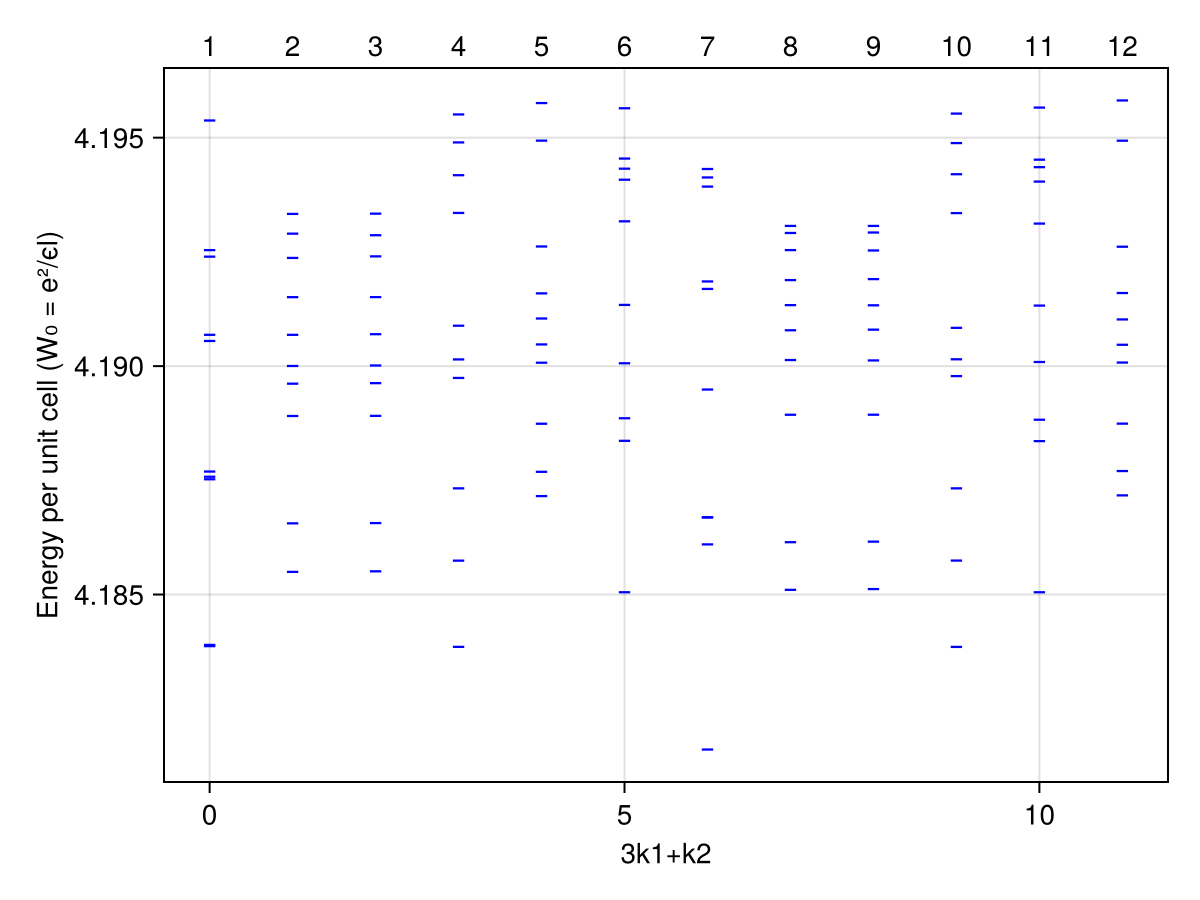

((energies[7])[1] / Nk) / LLT.W0 = 4.181606321055077
  0.169885 seconds (82.91 k allocations: 5.316 MiB, 19.65% compilation time)
maximum(abs.(imag.(str_fac210))) = 4.6191847315165285e-18
extrema(real.(str_fac210)) = (3.4030227222969604e-21, 2.014529063621477)
str_fac210[index_shift..., 1, 2] = 2.014529063621477 - 2.529805069132844e-19im
str_fac210[index_shift..., 2, 1] = 1.3478623969548107 + 2.8912057932946783e-19im


1.3478623969548107 + 2.8912057932946783e-19im

In [ ]:
plot_ed_spectrum() # 2, 10
@show energies[7][1]/Nk/LLT.W0
myvec210 = vectors[7][1]
@time str_fac210 = structure_factor_expectation(myvec210);
@show maximum(abs.(imag.(str_fac210)));
@show extrema(real.(str_fac210));
@show str_fac210[index_shift..., 1,2];
@show str_fac210[index_shift..., 2,1];

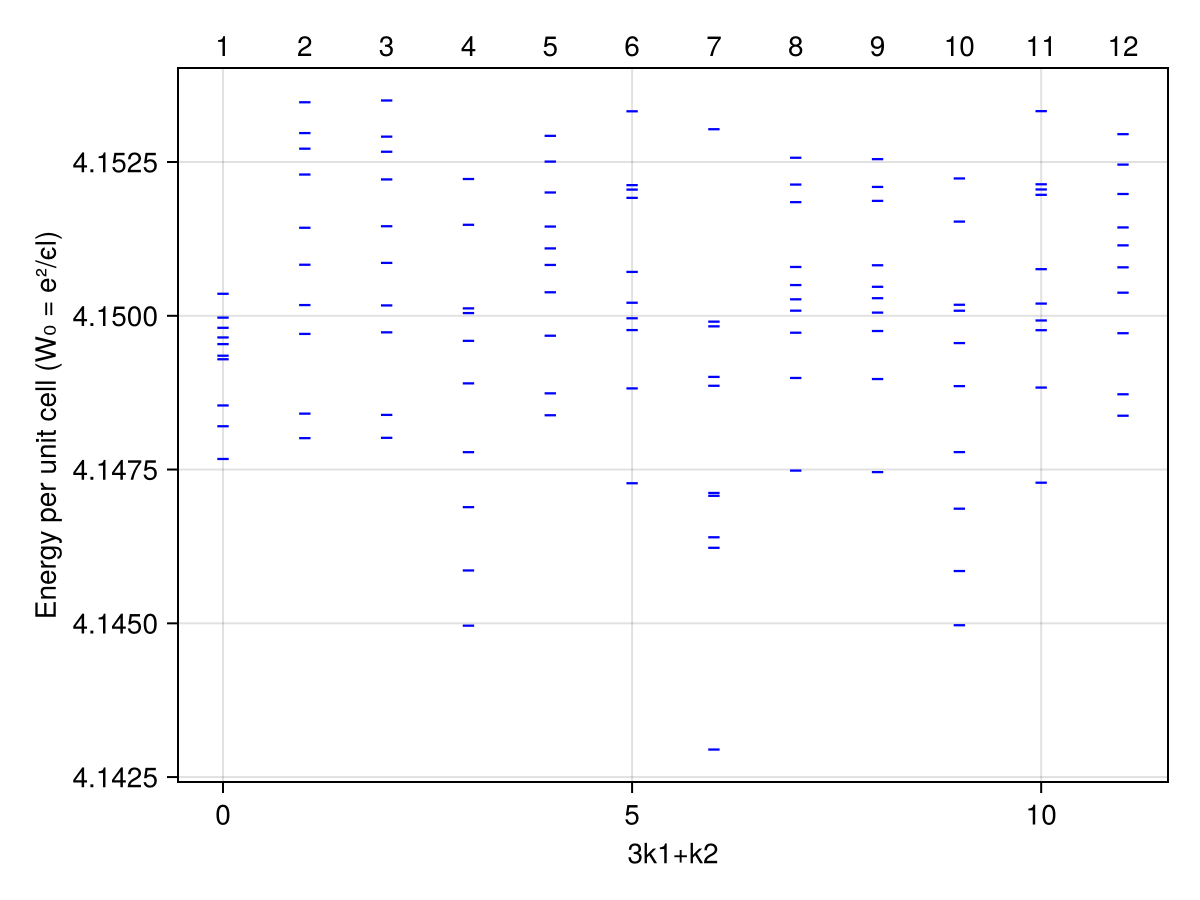

((energies[7])[1] / Nk) / LLT.W0 = 4.142947469829269
  0.951739 seconds (82.87 k allocations: 5.314 MiB, 3.59% compilation time)
maximum(abs.(imag.(str_fac39))) = 2.0599841277224584e-18
extrema(real.(str_fac39)) = (1.0002341618127468e-20, 1.6883833660039553)
str_fac39[index_shift..., 1, 2] = 1.6883833660039553 - 3.6140072416183483e-19im
str_fac39[index_shift..., 2, 1] = 1.1883833660039576 + 2.8912057932946783e-19im


1.1883833660039576 + 2.8912057932946783e-19im

In [ ]:
plot_ed_spectrum() # 3, 9
@show energies[7][1]/Nk/LLT.W0
myvec39 = vectors[7][1]
@time str_fac39 = structure_factor_expectation(myvec39);
@show maximum(abs.(imag.(str_fac39)));
@show extrema(real.(str_fac39));
@show str_fac39[index_shift..., 1,2];
@show str_fac39[index_shift..., 2,1];

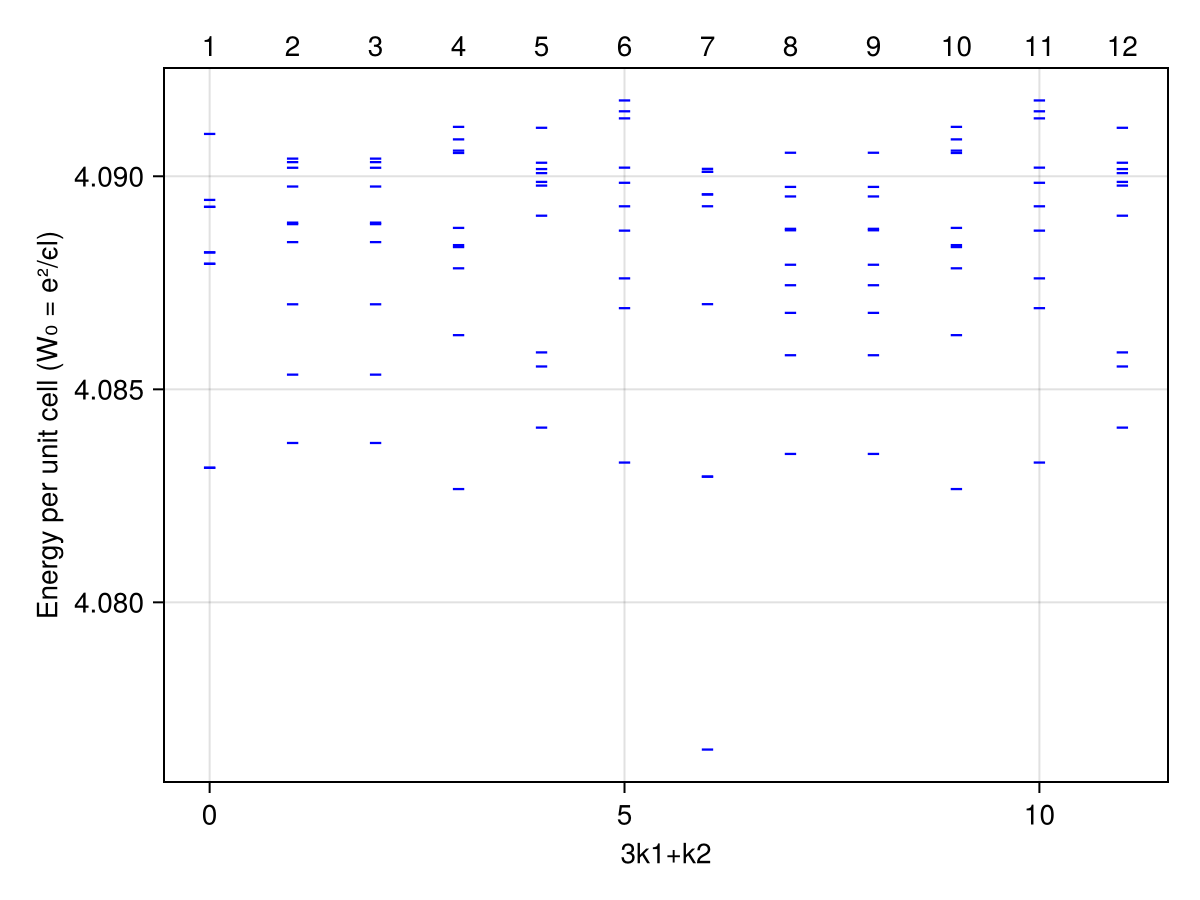

((energies[7])[1] / Nk) / LLT.W0 = 4.07654572060368
  5.068672 seconds (1.36 M allocations: 66.424 MiB, 0.31% gc time, 17.72% compilation time)
maximum(abs.(imag.(str_fac48))) = 1.5472468503178554e-18
extrema(real.(str_fac48)) = (1.5399676772682734e-20, 2.6531063384616496)
str_fac48[index_shift..., 1, 2] = 2.6531063384616496 + 1.4117215787571672e-22im
str_fac48[index_shift..., 2, 1] = 2.3197730051283174 - 1.676419374774136e-22im


In [11]:
plot_ed_spectrum() # 4, 8
@show energies[7][1]/Nk/LLT.W0
myvec48 = vectors[7][1]
@time str_fac48 = structure_factor_expectation(myvec48);
@show maximum(abs.(imag.(str_fac48)));
@show extrema(real.(str_fac48));
@show str_fac48[index_shift..., 1,2];
@show str_fac48[index_shift..., 2,1];

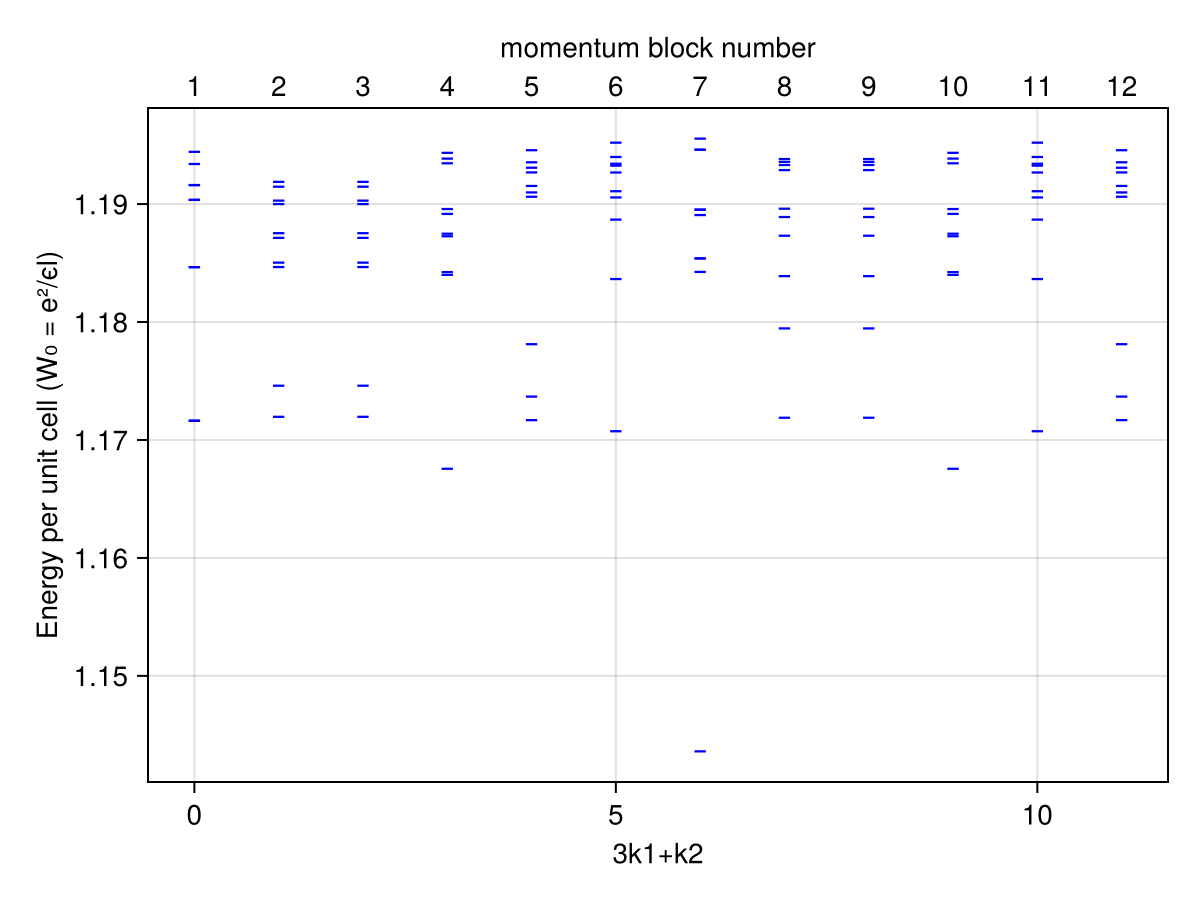

((energies[7])[1] / Nk) / LLT.W0 = 1.1435990230510613
 13.000177 seconds (82.78 k allocations: 5.336 MiB, 0.30% compilation time)
maximum(abs.(imag.(str_fac57))) = 1.7331814778956207e-18
extrema(real.(str_fac57)) = (-4.263256414560601e-14, 3.4903717503870655)
str_fac57[index_shift..., 1, 2] = 3.4903717503870655 + 0.0im
str_fac57[index_shift..., 2, 1] = 3.323705083720395 + 0.0im


3.323705083720395 + 0.0im

In [34]:
plot_ed_spectrum() # 5, 7
@show energies[7][1]/Nk/LLT.W0
myvec57 = vectors[7][1]
@time str_fac57 = structure_factor_expectation(myvec57);
@show maximum(abs.(imag.(str_fac57)))
@show extrema(real.(str_fac57))
@show str_fac57[index_shift..., 1,2]
@show str_fac57[index_shift..., 2,1]

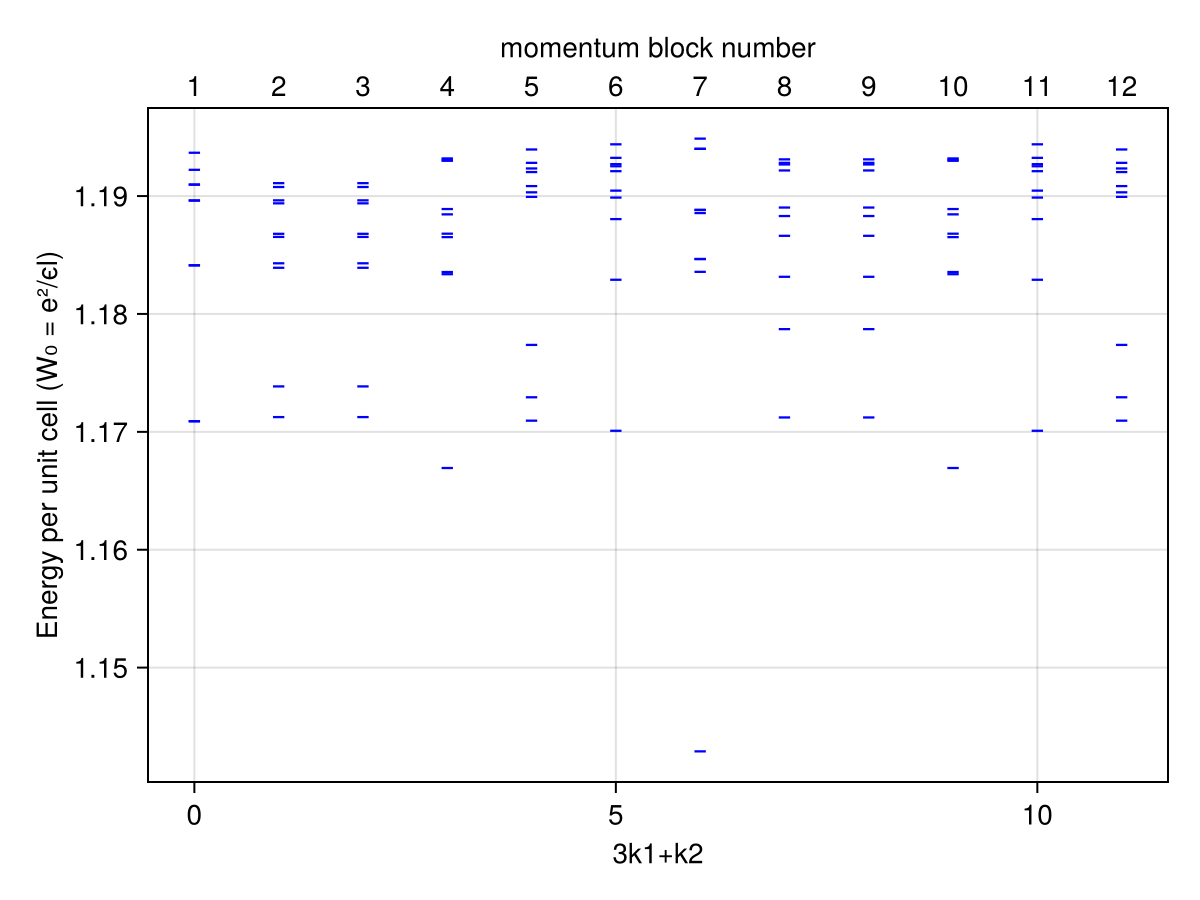

((energies[7])[1] / Nk) / LLT.W0 = 1.1428967312201002
 17.188854 seconds (82.80 k allocations: 5.337 MiB, 0.20% compilation time)
maximum(abs.(imag.(str_fac66))) = 1.1683545305575636e-18
extrema(real.(str_fac66)) = (2.8911227845149823e-20, 3.4896829114393615)
str_fac66[index_shift..., 1, 2] = 3.489682911439361 + 3.3658065289429835e-29im
str_fac66[index_shift..., 2, 1] = 3.4896829114393615 - 1.6829032644714918e-29im


3.4896829114393615 - 1.6829032644714918e-29im

In [39]:
plot_ed_spectrum() # 6, 6
@show energies[7][1]/Nk/LLT.W0
myvec66 = vectors[7][1]
@time str_fac66 = structure_factor_expectation(myvec66);
@show maximum(abs.(imag.(str_fac66)))
@show extrema(real.(str_fac66))
@show str_fac66[index_shift..., 1,2]
@show str_fac66[index_shift..., 2,1]

Plot structure factors (when layer indices are different, it's equivalent to exciton density)

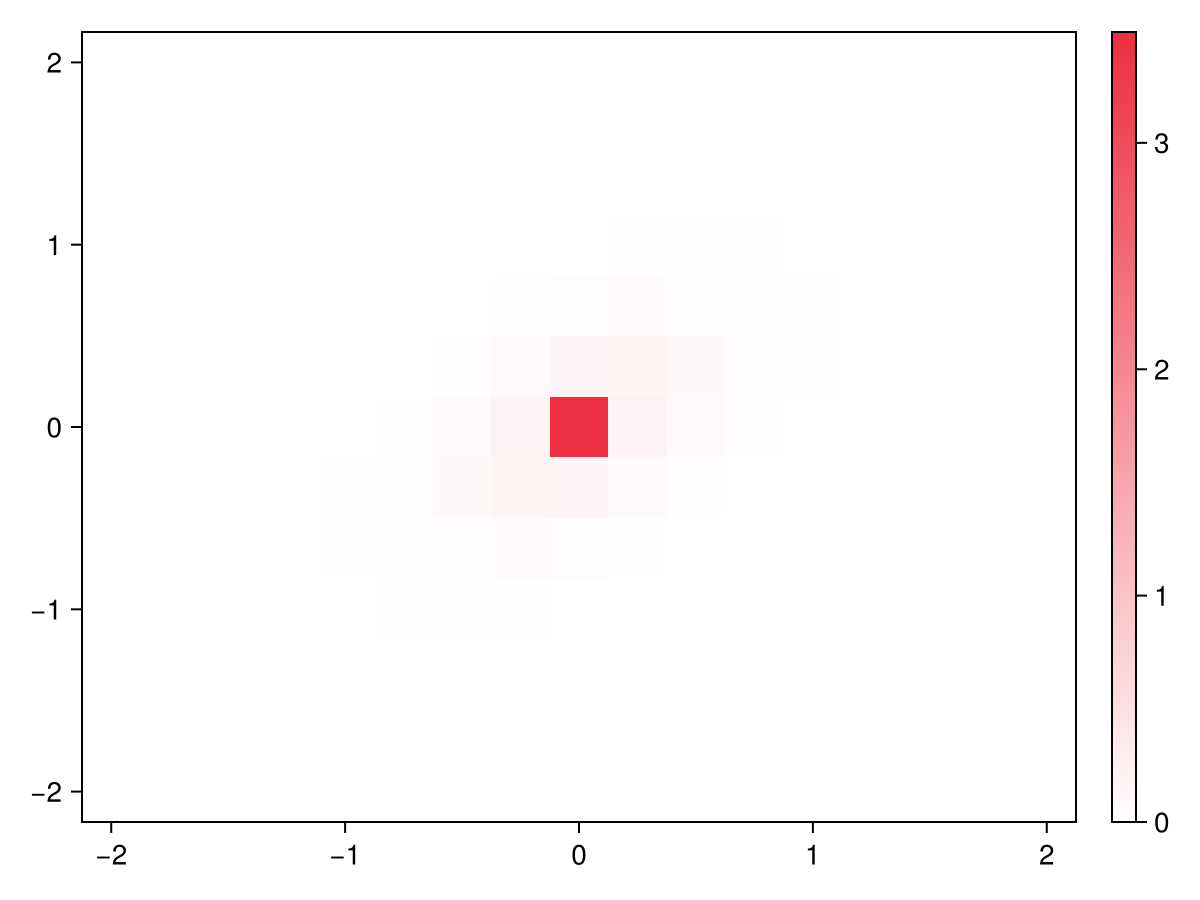

CairoMakie.Screen{IMAGE}


In [42]:
let structure_factor = str_fac66, layer = (1,2)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end

Calculate inter-layer momentum shift

In [9]:
# top-layer shift path
Npath = 15
path = Tuple{Float64, Float64}[]
for i in 0:Npath
    push!(path, ((Npath-i)/Npath, i/Npath))
end
path

16-element Vector{Tuple{Float64, Float64}}:
 (1.0, 0.0)
 (0.9333333333333333, 0.06666666666666667)
 (0.8666666666666667, 0.13333333333333333)
 (0.8, 0.2)
 (0.7333333333333333, 0.26666666666666666)
 (0.6666666666666666, 0.3333333333333333)
 (0.6, 0.4)
 (0.5333333333333333, 0.4666666666666667)
 (0.4666666666666667, 0.5333333333333333)
 (0.4, 0.6)
 (0.3333333333333333, 0.6666666666666666)
 (0.26666666666666666, 0.7333333333333333)
 (0.2, 0.8)
 (0.13333333333333333, 0.8666666666666667)
 (0.06666666666666667, 0.9333333333333333)
 (0.0, 1.0)

In [10]:
sn = 7                     # subspace number
Neigen = 15
path_energies = similar(path, Vector{Float64})

for i in eachindex(path_energies)
    println("path #$i = $(path[i])")
    scat_list2_shift = ED_sortedScatterList_twobody(para_conserve, kshift = [path[i], (1.0,0.0)]);
    path_energies[i], _ = EDsolve(subspaces[sn], scat_list2_shift, scat_list1_conserve;
        N = Neigen, showtime = true, ishermitian = true
    )
end
path_energies

path #1 = (1.0, 0.0)
  0.842066 seconds (768.38 k allocations: 534.796 MiB, 18.46% gc time, 125.71% compilation time)
  5.743094 seconds (5.66 M allocations: 822.760 MiB, 3.83% gc time, 53.83% compilation time)
path #2 = (0.9333333333333333, 0.06666666666666667)
  0.383081 seconds (21.27 k allocations: 497.934 MiB, 42.84% gc time)
  3.215730 seconds (25.18 k allocations: 573.833 MiB, 1.83% gc time)
path #3 = (0.8666666666666667, 0.13333333333333333)
  0.354961 seconds (21.27 k allocations: 497.934 MiB, 37.71% gc time)
  3.076958 seconds (24.72 k allocations: 555.074 MiB, 5.79% gc time)
path #4 = (0.8, 0.2)
  0.349498 seconds (21.27 k allocations: 497.934 MiB, 37.58% gc time)
  3.064402 seconds (24.27 k allocations: 536.316 MiB, 5.43% gc time)
path #5 = (0.7333333333333333, 0.26666666666666666)
  0.360693 seconds (21.27 k allocations: 497.934 MiB, 38.54% gc time)
  3.325833 seconds (25.19 k allocations: 573.835 MiB, 5.25% gc time)
path #6 = (0.6666666666666666, 0.3333333333333333)
  0.3

16-element Vector{Vector{Float64}}:
 [48.91854866872882, 48.995410417679, 48.99541046434041, 49.043983263079014, 49.071557785440284, 49.07489976082284, 49.07489976461833, 49.08124641490401, 49.08124642831081, 49.08209349016471, 49.083119701231155, 49.08311971982402, 49.10952793768442, 49.11464964524021, 49.11464968006874]
 [48.91854866872883, 48.99541041767907, 48.99541046434036, 49.04398326307909, 49.07155778544032, 49.07489976082298, 49.07489976461842, 49.08124641490389, 49.08124642831065, 49.08209349016481, 49.08311970123108, 49.08311971982391, 49.10952793768434, 49.11464964524021, 49.114649680068645]
 [48.918548668728654, 48.99541041767906, 48.99541046434045, 49.043983263078985, 49.071557785440255, 49.07489976082291, 49.074899764618415, 49.08124641490396, 49.08124642831095, 49.082093490164745, 49.08311970123119, 49.08311971982398, 49.10952793768455, 49.11464964524012, 49.1146496800687]
 [48.91854866872872, 48.995410417679025, 48.995410464340274, 49.043983263079056, 49.0715577854404

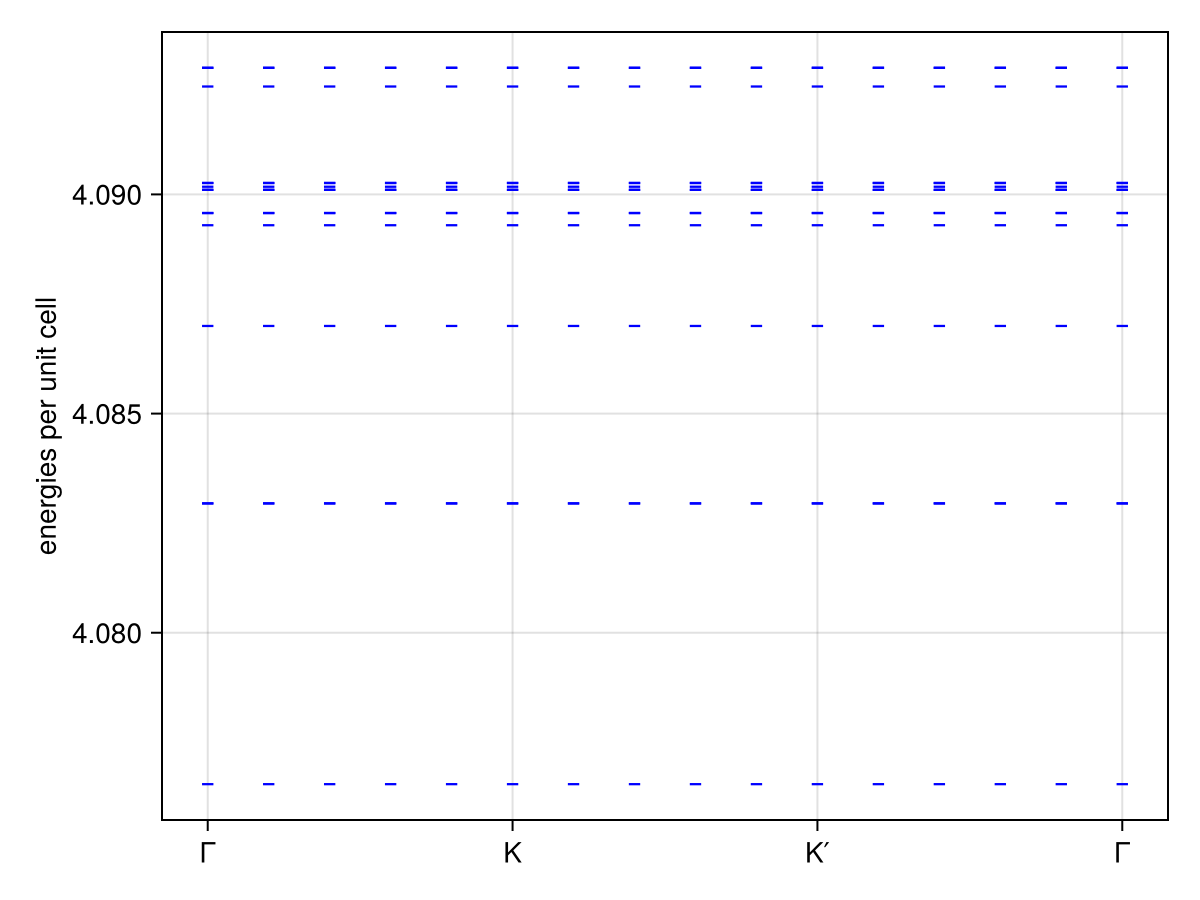

In [15]:
fig = Figure();
ax = Axis(fig[1,1];
    ylabel = "energies per unit cell",
    xticks = ([0, Npath/3, 2Npath/3, Npath], ["Γ", "K", "K′", "Γ"])
)
for (i, engs) in enumerate(path_energies)
    for e in engs
        scatter!(ax, i-1, e/Nk/LLT.W0, color = :blue, marker=:hline)
    end
end
# ylims!(4.076, 4.077)
fig